# Inference for Classification and Object detection

## 1.0 Introduction
This is the final notebook for the algorithm that belongs to the MSc graduation research. The .keras file and the weights and configuration file of the object detector will be used here for inference. First we start by upgrading a relevant package and then importing all the libraries. A data-frame is then created with the relevant columns we shall be needing. The classifier will run through the test images and label the images accordingly. The object detector will then run through all the images with material label "metal".

In [2]:
#uncomment below line if you don't have the latest openCV
#!pip install opencv-python --upgrade

In [1]:
#Necessary libraries
import pandas as pd
import os

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt

import cv2

from PIL import Image
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#check if needed
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score #use when

%matplotlib inline

c:\Users\Richie\anaconda3\envs\AItech\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Richie\anaconda3\envs\AItech\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Richie\anaconda3\envs\AItech\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\Richie\anaconda3\envs\AItech\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [5]:
print('Current tensorflow version:',tf.__version__)
print('Current numpy version:',np.__version__)
print('Current pandas version:',pd.__version__)
print('Current openCV version:',cv2.__version__)

Current tensorflow version: 2.9.1
Current numpy version: 1.22.4
Current pandas version: 1.4.3
Current openCV version: 4.6.0


In [2]:
#connect to my google drive if you use colab
#%cd ..
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


## 2.0 Creating dataframe


### 2.1 Load the main data frame

In [2]:
#load csv wth geo-locations
df=pd.read_csv('C:/Users/Richie/Desktop/MsC_CME_2/Graduation/Witteveen_data/01-Data/HighResolution_Positions.csv',index_col='Filename') 
#Drop unnecessary columns 
df.drop(['SurveyName', 'ORIG_Name','cameraX','cameraY','cameraZ'], axis=1, inplace=True)
#Will add column names that we need
df=df.reindex(columns=df.columns.to_list()+['Distance bumps','Reference object','Height','Material','Rust grade'])
pd.reset_option('display.max_rows', None) #To reset
df

,cameraLon,cameraLat,cameraAlt,Distance bumps,Reference object,Height,Material,Rust grade
Filename,,,,,,,,
HighRes_10541,6.216486,53.237703,0.35,NaN,NaN,NaN,NaN,NaN
HighRes_10542,6.216483,53.237703,0.25,NaN,NaN,NaN,NaN,NaN
HighRes_10543,6.216485,53.237704,0.20,NaN,NaN,NaN,NaN,NaN
HighRes_10544,6.218342,53.237293,-3.46,NaN,NaN,NaN,NaN,NaN
HighRes_10545,6.218486,53.237307,-3.57,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
HighRes_10536,6.225120,53.238759,0.42,NaN,NaN,NaN,NaN,NaN
HighRes_10537,6.225196,53.238789,0.39,NaN,NaN,NaN,NaN,NaN
HighRes_10538,6.225256,53.238827,0.33,NaN,NaN,NaN,NaN,NaN


### 2.2 Subsetting df based on test images

In [3]:
#Set the path for the test images
path = "C:/Users/Richie/Desktop/MsC_CME_2/Graduation/Witteveen_data/04-Test_uploads/Test"
#path='C:/Users/Richie/Desktop/MsC_CME_2/Graduation/Witteveen_data/04-Test_uploads/OneDrive_1_7-4-2022/undecided'
dir_list = os.listdir(path)

names=[]
for name in dir_list:
    names.append(name.split('.')[0]) #split the filename where '.' is located
    #print(name.split('_')[1].split('.'))

#Create a subdataframe with the test images
df2=df.loc[names]
#print(names)

## 3.0 Classification inference
Set the general path and the path of the models and then load one.

### 3.1 Load the model and set the switch statement

In [4]:
#Define paths to model and model self
models_path='C:/Users/Richie/Desktop/MsC_CME_2/Graduation/Witteveen_data/05-models/01-Classification/'
class4mod='4c/W+B_CNN_ep30_4c_resblok_5b_noaugm_filt32_run0.keras'#'4c/W+B_CNN_ep40_4c_07_07_run0.keras'
class6mod='6c/W+B_CNN_ep50_6c_Resblok_6b_augm_32-256_run2.keras'

#load model
model = keras.models.load_model(models_path+class4mod)#/content/W+B_CNN_ep30+Aug+Rescon.keras
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 32  896         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [5]:
#Run this if you're using the 4 class classifier, can make an if-statement later
def class_label(score_im):
    switch={0:('Grass','Grass'),
            1:('Metal','M-bad'),
            2:('Metal','M-good'),
            3:('Rock','Rock')}
    return switch.get(score_im)

In [5]:
#Run this if you're using the 6 class classifier
def class_label(score_im):
    switch={0:('Grass','Grass'),
            1:('Metal','M-acceptable'),
            2:('Metal','M-bad'),
            3:('Metal','M-good'),
            4:('Metal','M-moderate'),
            5:('Rock','Rock')}
    return switch.get(score_im)

### 3.2 Run the classifier

In [6]:
for name in names:
    img = keras.preprocessing.image.load_img(
      f"{path}/{name}.jpg", target_size=(400,400))        #Change path and ratio if different folder
    

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)                # Create batch axis

    predictions = model.predict(img_array)                  #will predict the class of the image
    index_scores=np.argsort(predictions[0])                 #value with max index is at the end
    class_lab=class_label(index_scores[-1])                 #gives tuple with (material, grade), in case not metal then grade=nan

    df2.loc[f'{name}','Material']=class_lab[0]              #insert relevant data into dataframe
    df2.loc[f'{name}','Rust grade']=class_lab[1]
  

1/1 [==============================] - 0s 79ms/step


In [7]:
#df2.sort_values(by=['Filename'], inplace=True) #To sort by the the index column
#pd.set_option('display.max_rows', None) #To show all values in dataframe
#pd.reset_option('display.max_rows', None) #To reset
#df2

## 4.0 Inference object detection

In [7]:
listmetal=df2.loc[df2['Material'] == 'Metal'].index #Get all the names in which metal was detected
#print(listmetal,'\n amount of images:',len(listmetal))

### 4.1 Set the paths and load model

In [8]:
classes_names=['Dim','Ref'] #Define the class names

#paths to the weights and configuration file
#yoloweight='/content/gdrive/MyDrive/ColabNotebooks/YOLO/backup/yolov4-obj_last.weights'
yoloweight='C:/Users/Richie/Desktop/MsC_CME_2/Graduation/Witteveen_data/05-models/02-Object_detection/yolov4-obj_best.weights'
yoloconfig='C:/Users/Richie/Desktop/MsC_CME_2/Graduation/Witteveen_data/05-models/02-Object_detection/yolov4-obj.cfg'
outputpath='C:/Users/Richie/Desktop/MsC_CME_2/Graduation/Witteveen_data/03-Foto/04-Yolo/detections/'

#Load the model for object detection
model_OD=cv2.dnn.readNet(yoloweight,yoloconfig, framework='DarkNet')
layer_names = model_OD.getLayerNames()
COLORS = [(0,255,0),(0,0,255)]#np.random.uniform(0, 255, size=(len(classes_names), 3)) #Colors [green, red]
output_layers=[layer_names[i-1] for i in model_OD.getUnconnectedOutLayers()]

In [9]:
for name in listmetal: 
    image = cv2.imread(f"{path}/{name}.jpg")
    #image=cv2.resize(image, dsize=(416,416), interpolation=cv2.INTER_LINEAR)
    #image_height, image_width, _ = image.shape
    height, width, channels = image.shape
    # create blob from image
    blob = cv2.dnn.blobFromImage(image=image, scalefactor=1/255, size=(416, 416),mean=(0,0,0), crop=False)
    # set the blob to the model
    model_OD.setInput(blob)
    # forward pass through the model to carry out the detection
    outputs = model_OD.forward(output_layers)

    #Use the outputs to get the info we want such as class id, confidence and bounding box data
    class_ids = []
    confidences = []
    boxes = []
    for output in outputs:  
        for identi in output:
            scores = identi[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            #print(scores,class_id,confidence)
            if confidence > 0.2:
                #
                # Object detected
                centerx = int(identi[0] * width)
                centery = int(identi[1] * height)
                w = int(identi[2] * width)
                h = int(identi[3] * height)
                # Rectangle coordinates
                x = int(centerx - w / 2)
                y = int(centery - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4) #Remove boxes that are overlaying on each other
    font = cv2.FONT_HERSHEY_COMPLEX
    #colors = np.random.uniform(0, 255, size=(len(classes_names), 3))

    #TODO
    pixel_to_act=0.6; #move this out of the for loop if images are of a sequence
  
    m=[boxes[i] for i in indexes]               #put all the relevant information in one matrix
    m=np.array(m)                               #convert to numpy matrix
    ids=[class_ids[i] for i in indexes ]        #put all the relevant class ids in one vector
    ids=np.array(ids).reshape(len(ids),1)       #convert to numpy vector
  
    if len(m)!=0:
        all=np.append(m,ids, axis=1)
        all=all[all[:, 0].argsort()]              #contains matrix with data in [x,y,w,h,class]
        mn=all[all[:,-1]==0]                      #slice the data that only contains bumps
        #Check for ref object
        if (1 in class_ids):
            
            df2.loc[f'{name}','Reference object']="Yes"
            Refs=all[all[:,-1]==1]                    #slice the data that only contains refs
            pixel_to_act=15/np.average(Refs[:,2])     #Divide actual size of ref object with the avg pixel width of ref object  
        else:
            df2.loc[f'{name}','Reference object']="No"

        #Check if Dim has been detected
        if (0 in class_ids):
            avg_pix_width=np.average(mn[:,2])                       #Calculate average pixel width
            height=(np.average(mn[:,3])*pixel_to_act).round(1)      #calculate the height and round to 0.1
            df2.loc[f'{name}','Height']=height
      
            #Calculate distance bumps 
            centers_x=mn[:,0]+mn[:,2]/2                             #Get the centers again
            distance_list=[]                                        #Empty list to store distances
            for a in range(len(centers_x)-1):                       #Calculate all the distance between centers           
            #print(centers_x[a],mn[a,2])
                if (centers_x[a]+mn[a,2])<(centers_x[a+1]-mn[a+1,2]): #make sure the 2nd center doesn't sit on the 1st enter
                    distance=centers_x[a+1]-centers_x[a]                #calculate the distance
                    if distance>(0.5*avg_pix_width) and distance<(3.5*avg_pix_width):                      #if the distance is way too small or big  then drop it
                        distance_list.append(distance)
            avg_dist=np.average(distance_list)*pixel_to_act if len(distance_list)!=0 else np.nan       #Check if there are distances before averaging
            df2.loc[f'{name}','Distance bumps']=np.round(avg_dist,1)            #Insert the value and round to 0.1

        #TODO: Create a function for this
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                confidence = str("{:.2f}".format(confidences[i]))
                label = str(classes_names[class_ids[i]]+confidence)
                color = COLORS[class_ids[i]]
                cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                cv2.putText(image, label,(x, y + 20), font, 0.6, color, 2)
        cv2.imwrite(f'{outputpath}od_4c_{name}.png',image)  #comment out if you don't want to save

    else:#If model detects nothing write 'Could Not Detect' 
        df2.loc[f'{name}','Height']='CND'
        df2.loc[f'{name}','Reference object']='CND'
        df2.loc[f'{name}','Distance bumps']='CND'
      #Return Height,refobj, pixel_to

In [10]:
#Check the full df
df2.sort_values(by=['Filename'], inplace=True)
pd.set_option('display.max_rows', None)
df2

,cameraLon,cameraLat,cameraAlt,Distance bumps,Reference object,Height,Material,Rust grade
Filename,,,,,,,,
HighRes_01386,5.692051,52.968265,-1.51,NaN,NaN,NaN,Grass,Grass
HighRes_01387,5.692022,52.968320,-1.51,NaN,NaN,NaN,Grass,Grass
HighRes_01388,5.691991,52.968376,-1.51,NaN,NaN,NaN,Grass,Grass
HighRes_01389,5.691958,52.968430,-1.52,NaN,NaN,NaN,Grass,Grass
HighRes_01390,5.691923,52.968484,-1.54,NaN,NaN,NaN,Grass,Grass
HighRes_01605,5.690281,52.975704,-0.92,NaN,NaN,NaN,Grass,Grass
HighRes_01606,5.690255,52.975772,-0.92,NaN,NaN,NaN,Grass,Grass
HighRes_01735,5.688134,52.983188,-0.38,NaN,NaN,NaN,Rock,Rock
HighRes_01736,5.688145,52.983254,-0.34,NaN,NaN,NaN,Rock,Rock


### 4.2 Join with more data

In [24]:
#load file created from GIS software
df11=pd.read_csv('C:/Users/Richie/Desktop/MsC_CME_2/Graduation/Witteveen_data/01-Data/Goed_slechte_foto.csv',sep=";")
df11=df11.iloc[:7348,:] #splice so only relevant rows are taken

#df11['Link']=df11['hires_link'] #Store link in another column, uncommennt of not needed
#Split values in hires limk to get the filename
df11[['hires_link','Filename']]=df11['hires_link'].str.split('PMK/',1, expand=True)#split beweetn link and highres_xxxx.jpg
df11[['Filename','Filename_nr']]=df11['Filename'].str.split('.',1, expand=True)#split between higres_xxxx and jpg
#drop useless stuff
df11.drop(['hires_link', 'Filename_nr'], axis=1, inplace=True)
df11=df11.set_index('Filename')
#merge the previous dataframe with the latest and join the columns
df2=df2.join(df11, on='Filename')

### 4.3 Save the DF

In [11]:
# saving the dataframe
df2.to_csv('inference-df_4class.csv')

## 5.0 Verification: Confusion matrix for classifiers
This section was used to make confusion matrix and calculate the accuracy of the models. This is only needed to verify that the

### 5.1 Classification

In [6]:
#Paths of all models
#Define paths to model and model self and create a list
models_path6c='C:/Users/Richie/Desktop/MsC_CME_2/Graduation/Witteveen_data/05-models/01-Classification/6c_var/'
models_path='C:/Users/Richie/Desktop/MsC_CME_2/Graduation/Witteveen_data/05-models/01-Classification/'
crosval_path='C:/Users/Richie/Desktop/MsC_CME_2/Graduation/Witteveen_data/05-models/01-Classification/4c/'

model_listraw = os.listdir(models_path6c) #insert relevant path

#function to get the keras files
def add_jpg(orig_list):
    newlist=[]
    for names in orig_list:
        if names.endswith('.keras')==True:
            newlist.append(names)
    return newlist
modelnames=add_jpg(model_listraw)

#create df to store all accuracy results
df_testacc=pd.DataFrame(columns=['Accuracy material','Acuracy rust grade'],index=modelnames)
df_testacc

,Accuracy material,Acuracy rust grade
W+B_CNN_6c_inception_6b_augm_filt32_50ep.keras,NaN,NaN
W+B_CNN_6c_inception_6b_noaugm_filt32_50ep.keras,NaN,NaN
W+B_CNN_6c_Resblock_6b_augm_filt32-256_50ep.keras,NaN,NaN
W+B_CNN_6c_resblok_6b_noaugm_filt32_run0.keras,NaN,NaN
W+B_CNN_6c_vgg16_5b_noaugm_filt32.keras,NaN,NaN
W+B_CNN_6c_vgg16_6b_noaugm_filt32_50ep.keras,NaN,NaN
W+B_CNN_ep30_6c_incept_noaugm_32_run0.keras,NaN,NaN
W+B_CNN_ep40_6c_resblock_noaugm_filt32-256.keras,NaN,NaN


In [13]:
#function to get classes in sorted order
#def Get_classes(series):
#  classes=set(series)
#  classes.sort()
#  return classes

#Ground truths for material
y_test_mat=['Grass','Grass','Grass','Grass','Grass','Grass', 'Grass','Rock', 'Rock','Metal',
'Rock','Rock', 'Rock','Rock', 'Rock','Rock','Rock', 'Rock','Rock', 'Rock',
'Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal',
'Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal',
'Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal',
'Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal',
'Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal','Metal',
'Metal','Metal','Metal','Grass','Rock','Rock','Rock','Rock','Grass','Grass',
'Grass','Grass','Grass','Grass','Grass','Grass','Grass','Grass','Grass','Grass',
'Grass','Grass','Rock', 'Rock','Rock', 'Rock','Rock','Rock', 'Rock','Rock']
#y_pred_mat=pred_mat
#classes_mat=set(pred_mat)

#Ground truth rustgrade 4 classes
y_test_rg4c=['Grass','Grass','Grass','Grass','Grass','Grass', 'Grass','Rock', 'Rock','M-good',
'Rock','Rock', 'Rock','Rock', 'Rock','Rock','Rock', 'Rock','Rock', 'Rock',
'M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-good',
'M-good','M-good','M-good','M-good','M-bad','M-bad','M-bad','M-bad','M-bad','M-bad',
'M-bad','M-bad','M-bad','M-good','M-good','M-good','M-good','M-good','M-good','M-good',
'M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-good',
'M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-bad','M-bad',
'M-bad','M-bad','M-good','Grass','Rock','Rock','Rock','Rock','Grass','Grass',
'Grass','Grass','Grass','Grass','Grass','Grass','Grass','Grass','Grass','Grass',
'Grass','Grass','Rock', 'Rock','Rock', 'Rock','Rock','Rock', 'Rock','Rock']

#Ground truth rustgrade 6 classes
y_test_rg6c=['Grass','Grass','Grass','Grass','Grass','Grass', 'Grass','Rock', 'Rock','M-acceptable',
'Rock','Rock', 'Rock','Rock', 'Rock','Rock','Rock', 'Rock','Rock', 'Rock',
'M-acceptable','M-acceptable','M-acceptable','M-acceptable','M-acceptable','M-acceptable','M-acceptable','M-acceptable','M-acceptable','M-acceptable',
'M-acceptable','M-acceptable','M-acceptable','M-acceptable','M-bad','M-bad','M-moderate','M-moderate','M-moderate','M-moderate',
'M-moderate','M-moderate','M-bad','M-good','M-good','M-good','M-good','M-good','M-good','M-good',
'M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-good',
'M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-good','M-moderate','M-moderate',
'M-moderate','M-moderate','M-acceptable','Grass','Rock','Rock','Rock','Rock','Grass','Grass',
'Grass','Grass','Grass','Grass','Grass','Grass','Grass','Grass','Grass','Grass',
'Grass','Grass','Rock', 'Rock','Rock', 'Rock','Rock','Rock', 'Rock','Rock']
#y_pred_rg=pred_rg
#classes_rg6c=set(y_pred_rg)

In [22]:
def class_label(score_im): #change accroding to classes
    #switch={
    #    0:('Grass',np.nan),
    #    1:('Metal','bad'),
    #    2:('Metal','good'),
    #    3:('Rock',np.nan)}
    switch={0:('Grass','Grass'),
            #1:('Metal','M-acceptable'),
            1:('Metal','M-bad'),
            2:('Metal','M-good'),
            #4:('Metal','M-moderate'),
            3:('Rock','Rock')}
    return switch.get(score_im)

#### 5.1.1 Loop through one model

In [23]:
model = keras.models.load_model(models_path+'/4c/W+B_CNN_ep30_4c_resblok_5b_noaugm_filt32_run0.keras')
#model = keras.models.load_model(models_path+'/6c/W+B_CNN_ep50_6c_resblok_6b_augm_32-256_run2.keras')#W+B_CNN_ep30_4c_resblok_5b_noaugm_filt32_run0
model.summary()
#empty list for predictions
pred_mat=[]
pred_rg=[]
for name in names:
    img = keras.preprocessing.image.load_img(
      f"{path}/{name}.jpg", target_size=(400,400))        #Change path and ratio if different folder
    

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)                # Create batch axis

    predictions = model.predict(img_array)                  #will predict the class of the image
    index_scores=np.argsort(predictions[0])                 #value with max index is at the end
    class_lab=class_label(index_scores[-1])                 #gives tuple with (material, grade), in case not metal then grade=nan

    pred_mat.append(class_lab[0])
    pred_rg.append(class_lab[1])
#print('mat: ',accuracy_score(y_test_mat,pred_mat))
#print('rg: ',accuracy_score(y_test_rg6c,pred_rg))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 32  896         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

#### 5.1.2 Loop through multiple models

In [56]:
#loop all the models
for model_file in modelnames:
    #load model
    model = keras.models.load_model(models_path6c+model_file) #Change the path
    #model.summary()
    pred_mat=[]
    pred_rg=[]
    for name in names:
        img = keras.preprocessing.image.load_img(
        f"{path}/{name}.jpg", target_size=(400,400))        #Change path and ratio if different folder
        

        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)                # Create batch axis

        predictions = model.predict(img_array)                  #will predict the class of the image
        index_scores=np.argsort(predictions[0])                 #value with max index is at the end
        class_lab=class_label(index_scores[-1])                 #gives tuple with (material, grade), in case not metal then grade=nan

        pred_mat.append(class_lab[0])
        pred_rg.append(class_lab[1])
    df_testacc.loc[f'{model_file}','Accuracy material']=accuracy_score(y_test_mat,pred_mat)
    df_testacc.loc[f'{model_file}','Acuracy rust grade']=accuracy_score(y_test_rg6c,pred_rg) #change this depending on the classes

        

1/1 [==============================] - 0s 210ms/step


In [57]:
df_testacc #6 classes

,Accuracy material,Acuracy rust grade
W+B_CNN_6c_inception_6b_augm_filt32_50ep.keras,0.84,0.66
W+B_CNN_6c_inception_6b_noaugm_filt32_50ep.keras,0.89,0.66
W+B_CNN_6c_Resblock_6b_augm_filt32-256_50ep.keras,0.93,0.68
W+B_CNN_6c_resblok_6b_noaugm_filt32_run0.keras,0.83,0.65
W+B_CNN_6c_vgg16_5b_noaugm_filt32.keras,0.84,0.57
W+B_CNN_6c_vgg16_6b_noaugm_filt32_50ep.keras,0.82,0.52
W+B_CNN_ep30_6c_incept_noaugm_32_run0.keras,0.91,0.65
W+B_CNN_ep40_6c_resblock_noaugm_filt32-256.keras,0.78,0.65


In [28]:
df_testacc #crossval

,Accuracy material,Acuracy rust grade
W+B_CNN_ep30_4c_resblok_5b_noaugm_filt32_run0.keras,0.99,0.96
W+B_CNN_ep30_4c_resblok_5b_noaugm_filt32_run1.keras,0.96,0.92
W+B_CNN_ep30_4c_resblok_5b_noaugm_filt32_run2.keras,0.9,0.85
W+B_CNN_ep40_4c_07_07_run0.keras,0.85,0.8
W+B_CNN_ep40_4c_07_07_run1.keras,0.93,0.88
W+B_CNN_ep40_4c_07_07_run2.keras,0.88,0.82


In [73]:
df_testacc

,Accuracy material,Acuracy rust grade
W+B_CNN_inception_4b_augm_filt32-256.keras,0.92,0.8
W+B_CNN_inception_5b_augm_filt32-256.keras,0.89,0.8
W+B_CNN_inception_5b_noaugm_filt32-256.keras,0.22,0.22
W+B_CNN_inception_5b_noaugm_filt32.keras,0.98,0.91
W+B_CNN_resbl_4b_augm.keras,0.92,0.83
W+B_CNN_resbl_5b_augm_filtincrease.keras,0.9,0.67
W+B_CNN_resbl_5b_noaugm_filt32.keras,0.99,0.96
W+B_CNN_resbl_5b_noaugm_filtincrease.keras,0.9,0.85
W+B_CNN_resb_4bl_filter32.keras,0.91,0.87
W+B_CNN_vgg16_4b_augm_filt32-256.keras,0.54,0.13


#### 5.1.3 Confusion matrice

In [24]:
#Get the confusion matrix
cf_matrix_mat = confusion_matrix(y_test_mat, pred_mat)
cf_matrix_rg = confusion_matrix(y_test_rg4c, pred_rg)

print(cf_matrix_mat)
print(cf_matrix_rg)

[[22  0  0]
 [ 0 53  1]
 [ 0  0 24]]
[[22  0  0  0]
 [ 0 11  2  0]
 [ 0  1 39  1]
 [ 0  0  0 24]]


In [26]:
print(classification_report(y_test_mat,pred_mat))
print(classification_report(y_test_rg4c,pred_rg))

              precision    recall  f1-score   support

       Grass       1.00      1.00      1.00        22
       Metal       1.00      0.98      0.99        54
        Rock       0.96      1.00      0.98        24

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

              precision    recall  f1-score   support

       Grass       1.00      1.00      1.00        22
       M-bad       0.92      0.85      0.88        13
      M-good       0.95      0.95      0.95        41
        Rock       0.96      1.00      0.98        24

    accuracy                           0.96       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.96      0.96      0.96       100



In [17]:

#Function to plot confusion matrixes
def Make_Heatmap(matrix,classes,horsize=8,title=str):
  plt.figure(figsize=(horsize,6))
  ax = sns.heatmap(matrix, annot=True, cmap='Blues')

  ax.set_title(f'Confusion Matrix for {title} with labels\n\n');
  ax.set_xlabel(f'\nPredicted {title} Category')
  ax.set_ylabel(f'Actual {title} Category ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'C5_confusionM_{title}.png',bbox_inches="tight")

  ## Display the visualization of the Confusion Matrix.
  plt.show()

In [18]:
classes_mat=['Grass','Metal','Rock']
Classes_rg4c=['Grass', 'M-bad', 'M-good', 'Rock']
Classes_rg6c=['Grass', 'M-acceptable', 'M-bad', 'M-good', 'M-moderate', 'Rock']

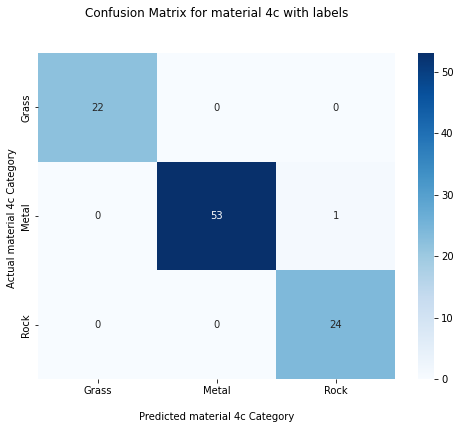

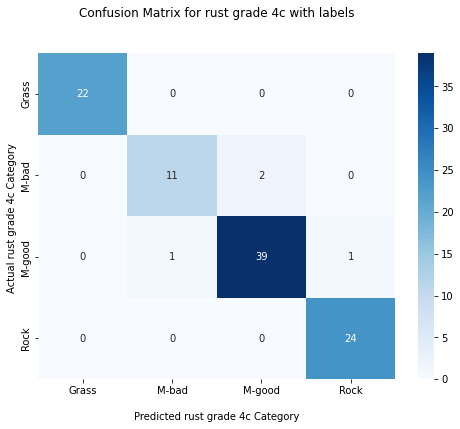

In [27]:
Make_Heatmap(cf_matrix_mat,classes_mat,8,'material 4c')
Make_Heatmap(cf_matrix_rg,Classes_rg4c,8,'rust grade 4c')

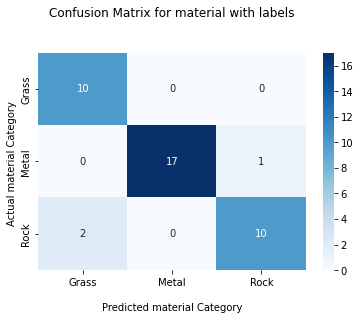

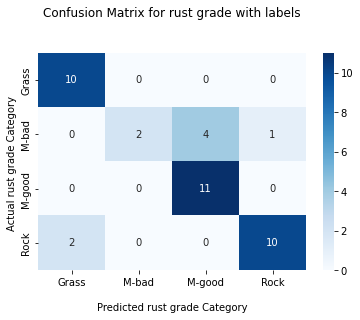

In [ ]:
Make_Heatmap(cf_matrix_mat,classes_mat,'material')
Make_Heatmap(cf_matrix_rg,classes_rg,'rust grade')

In [43]:
#function to get false positives etc in data frame
def Get_Pos_Neg(classes,matrix):
  df=pd.DataFrame(columns=['TP','TN','FN','FP'],index=classes)
  for i in range(len(matrix)):
    df.loc[f'{classes[i]}','TP']=matrix.diagonal()[i]
    df.loc[f'{classes[i]}','TN']=matrix.sum()-(matrix[i,:].sum()+matrix[:,i].sum()-matrix.diagonal()[i])
    df.loc[f'{classes[i]}','FN']=matrix[i].sum()-matrix.diagonal()[i]
    df.loc[f'{classes[i]}','FP']=matrix[:,i].sum()-matrix.diagonal()[i]
  return df

In [44]:
df_mat=Get_Pos_Neg(classes_mat,cf_matrix_mat)
df_mat

,TP,TN,FN,FP
Grass,9,30,1,0
Metal,18,22,0,0
Rock,12,27,0,1


In [45]:
df_rg=Get_Pos_Neg(classes_rg,cf_matrix_rg)
df_rg

,TP,TN,FN,FP
Grass,9,30,1,0
M-bad,6,33,1,0
M-good,11,28,0,1
Rock,12,27,0,1


In [51]:
print(classification_report(y_test_mat,pred_mat))
print(classification_report(y_test_rg4c,pred_rg))

              precision    recall  f1-score   support

       Grass       1.00      0.95      0.98        22
       Metal       0.98      0.87      0.92        54
        Rock       0.77      1.00      0.87        24

    accuracy                           0.92       100
   macro avg       0.92      0.94      0.92       100
weighted avg       0.93      0.92      0.92       100

              precision    recall  f1-score   support

       Grass       1.00      0.95      0.98        22
       M-bad       0.61      0.85      0.71        13
      M-good       0.90      0.66      0.76        41
        Rock       0.77      1.00      0.87        24

    accuracy                           0.83       100
   macro avg       0.82      0.86      0.83       100
weighted avg       0.85      0.83      0.83       100



In [ ]:
print(classification_report(y_test_mat,y_pred_mat))

              precision    recall  f1-score   support

       Grass       0.83      1.00      0.91        10
       Metal       1.00      0.94      0.97        18
        Rock       0.91      0.83      0.87        12

    accuracy                           0.93        40
   macro avg       0.91      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40



In [ ]:
print(classification_report(y_test_rg,y_pred_rg))

              precision    recall  f1-score   support

       Grass       0.83      1.00      0.91        10
       M-bad       1.00      0.29      0.44         7
      M-good       0.73      1.00      0.85        11
        Rock       0.91      0.83      0.87        12

    accuracy                           0.82        40
   macro avg       0.87      0.78      0.77        40
weighted avg       0.86      0.82      0.80        40



In [ ]:
print('Precision score: ',precision_score(y_test,y_pred, average=None))
print('Accuracy score: ',accuracy_score(y_test,y_pred))

Precision score:  [0.83333333 1.         0.90909091]
Accuracy score:  0.925


In [ ]:
accuracy_score(y_test,y_pred)

0.925

In [ ]:
df_conf=get_pos_neg(classes,cf_matrix)

In [ ]:
df_conf

,TP,TN,FN,FP
Grass,10,27,0,2
Rock,17,20,1,0
Metal,10,27,2,1


In [ ]:
z=df2.Material.unique()
z.sort()

In [ ]:
balanced_accuracy_score(y_test,y_pred)

0.9259259259259259

### 5.2 Object detection

## 6.0 Tests


### 6.1 Some functions

In [ ]:
#usefull functions to carefully check what happens in one image
def Forward_pass(im_name):
    
    image = cv2.imread(f"{im_name}")
    #image=cv2.resize(image, dsize=(416,416), interpolation=cv2.INTER_LINEAR)
    #image_height, image_width, _ = image.shape
    height, width, channels = image.shape
    # create blob from image
    blob = cv2.dnn.blobFromImage(image=image, scalefactor=1/255, size=(416, 416),mean=(0,0,0), crop=False)
    # set the blob to the model
    model_OD.setInput(blob)
    # forward pass through the model to carry out the detection
    im_outputs = model_OD.forward(output_layers)
    return im_outputs

def Bounding_box_coordinates(data):
    #from: https://www.imurgence.com/home/blog/how-to-do-object-detection-in-python-using-yolo
    class_ids = []
    confidences = []
    boxes = []
    for output in data:
        for identi in output:
            scores = identi[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            #print(scores,class_id,confidence)
            if confidence > 0.2:   
                # Object detected
                centerx = int(identi[0] * width)
                centery = int(identi[1] * height)
                w = int(identi[2] * width)
                h = int(identi[3] * height)
                # Rectangle coordinates
                x = int(centerx - w / 2)
                y = int(centery - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    return class_ids, confidences, boxes

def save_image():
    for i in range(len(boxes)):     
        if i in indexes:         
            x, y, w, h = boxes[i]
            confidence = str("{:.2f}".format(confidences[i]))
            label = str(classes_names[class_ids[i]]+confidence)
            color = colors[class_ids[i]]

            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image, label,(x, y + 20), font, 0.6, color, 2)

            cv2.imwrite(f'{outputpath}od_{name}.png',image) #comment out if you don't want to save


### 6.2 run classifier on one image

In [ ]:
def test_class(namepic):
  img = keras.preprocessing.image.load_img(
        f"{path}/{namepic}.jpg", target_size=(400,400))#Change path and ratio if different folder
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array) #will predict the class of the image
  return predictions

 

### 6.3 run yolo on one image

In [ ]:
def one_OD(namepic):
  # read the image from disk 
  #image = cv2.imread('/content/gdrive/MyDrive/ColabNotebooks/YOLO/HighRes_25776.jpg')
  image = cv2.imread(f'{path}/{namepic}.jpg')
  #image=cv2.resize(image, dsize=(416,416), interpolation=cv2.INTER_LINEAR)
  #image_height, image_width, _ = image.shape
  height, width, channels = image.shape
  # create blob from image
  blob = cv2.dnn.blobFromImage(image=image, scalefactor=1/255, size=(416, 416),mean=(0,0,0), crop=False)
  # set the blob to the model
  model_OD.setInput(blob)
  # forward pass through the model to carry out the detection
  outputs = model_OD.forward(output_layers)

  #from: https://www.imurgence.com/home/blog/how-to-do-object-detection-in-python-using-yolo
  class_ids = []
  confidences = []
  boxes = []
  for output in outputs:
    for identi in output:
      scores = identi[5:]
      class_id = np.argmax(scores)
      confidence = scores[class_id]
      #print(scores,class_id,confidence)
      if confidence > 0.2:
        # Object detected
        centerx = int(identi[0] * width)
        centery = int(identi[1] * height)
        w = int(identi[2] * width)
        h = int(identi[3] * height)
        # Rectangle coordinates
        x = int(centerx - w / 2)
        y = int(centery - h / 2)
        boxes.append([x, y, w, h])
        confidences.append(float(confidence))
        class_ids.append(class_id)

  indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)
  font = cv2.FONT_HERSHEY_COMPLEX
  colors = np.random.uniform(0, 255, size=(len(classes_names), 3))
  m=[boxes[i] for i in indexes]               #put all the relevant information in one matrix
  m=np.array(m)                               #convert to numpy matrix
  ids=[class_ids[i] for i in indexes ]        #put all the relevant class ids in one vector
  ids=np.array(ids).reshape(len(ids),1)       #convert to numpy vector
  pixel_to_act=0.6
  if len(m)==0:                               #If model detects nothing write 'Could Not Detect'
    print('no detections :(')
    #df2.loc[f'{name}','Height']='CND'
    #df2.loc[f'{name}','Reference object']='CND'
    #df2.loc[f'{name}','Distance bumps']='CND'
  else:
    all=np.append(m,ids, axis=1)
    all=all[all[:, 0].argsort()]              #contains matrix with data in [x,y,w,h,class]
    mn=all[all[:,-1]==0]                      #slice the data that only contains bumps
    Refs=all[all[:,-1]==1]                    #slice the data that only contains refs

    avg_pix_width=np.average(mn[:,2])                       #Calculate average pixel width
    height=(np.average(mn[:,3])*pixel_to_act).round(2)      #calculate the height
    #df2.loc[f'{name}','Height']=height

    for i in range(len(boxes)):
      if i in indexes:
        x, y, w, h = boxes[i]
        confidence = str("{:.2f}".format(confidences[i]))
        label = str(classes_names[class_ids[i]]+confidence)
        #color = colors[i]

        cv2.rectangle(image, (x, y), (x + w, y + h), 1, 2)
        cv2.putText(image, label,(x, y + 20), font, 0.6, (255,255,255), 2)

    cv2.imwrite('C4_single_od.png',image) #comment out if you don't want to save
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print(mn)

In [ ]:
one_OD('HighRes_25585')

no detections :(


In [ ]:
# read the image from disk 
image = cv2.imread('/content/gdrive/MyDrive/ColabNotebooks/YOLO/HighRes_25776.jpg')
#image = cv2.imread(f'{path}/HighRes_25585.jpg')
#image=cv2.resize(image, dsize=(416,416), interpolation=cv2.INTER_LINEAR)
#image_height, image_width, _ = image.shape
height, width, channels = image.shape
# create blob from image
blob = cv2.dnn.blobFromImage(image=image, scalefactor=1/255, size=(416, 416),mean=(0,0,0), crop=False)
# set the blob to the model
model_OD.setInput(blob)
# forward pass through the model to carry out the detection
outputs = model_OD.forward(output_layers)

#from: https://www.imurgence.com/home/blog/how-to-do-object-detection-in-python-using-yolo
class_ids = []
confidences = []
boxes = []
for output in outputs:
  for identi in output:
    scores = identi[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    #print(scores,class_id,confidence)
    if confidence > 0.2:
      # Object detected
      centerx = int(identi[0] * width)
      centery = int(identi[1] * height)
      w = int(identi[2] * width)
      h = int(identi[3] * height)
      # Rectangle coordinates
      x = int(centerx - w / 2)
      y = int(centery - h / 2)
      boxes.append([x, y, w, h])
      confidences.append(float(confidence))
      class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4) #was0.2
font = cv2.FONT_HERSHEY_COMPLEX
colors = np.random.uniform(0, 255, size=(len(classes_names), 3))
m=[boxes[i] for i in indexes] #put all the relevant information in one matrix
m=np.array(m) #convert to numpy matrix
ids=[class_ids[i] for i in indexes ] #put all the relevant class ids in one vector
ids=np.array(ids).reshape(len(ids),1) #convert to numpy vector
if len(m)==0:
  print('nothing detected')
#mn=np.append(m,ids, axis=1)
#mn=mn[mn[:, 0].argsort()] #Sort the matrix on the first columns

for i in range(len(boxes)):
  if i in indexes:
    x, y, w, h = boxes[i]
    confidence = str("{:.2f}".format(confidences[i]))
    label = str(classes_names[class_ids[i]]+confidence)
    color = colors[class_ids[i]]

    cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)#1
    cv2.putText(image, label,(x, y + 20), font, 0.6, color, 2)#(255,255,255)

cv2.imwrite('C4_single_od.png',image) #comment out if you don't want to save
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
m=[boxes[i] for i in indexes] #put all the relevant information in one matrix
mn=np.array(m) #convert to numpy matrix
mn=mn[mn[:, 0].argsort()] #Sort the matrix on the first columns
height=np.average(mn[:,3]).round(2) #calculate the height

## confusion matrix on validation set

In [6]:
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)

In [8]:
y_pred = model.predict(validation_dataset).argmax(axis=1)

: 

: 